In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
base_name = 'Combined1Distribution'
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{base_name}_ForManuscript_Conc.npy')

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 9867.0482, Test Loss: 2247.6893
Epoch [2/1000], Train Loss: 8696.4610, Test Loss: 2128.1082
Epoch [3/1000], Train Loss: 8354.3819, Test Loss: 2038.6902
Epoch [4/1000], Train Loss: 7735.9515, Test Loss: 1816.8213
Epoch [5/1000], Train Loss: 6541.7870, Test Loss: 1398.7100
Epoch [6/1000], Train Loss: 4559.5246, Test Loss: 912.1199
Epoch [7/1000], Train Loss: 3083.8806, Test Loss: 659.9518
Epoch [8/1000], Train Loss: 2343.6324, Test Loss: 517.6654
Epoch [9/1000], Train Loss: 1859.0361, Test Loss: 420.8511
Epoch [10/1000], Train Loss: 1542.1450, Test Loss: 340.1090
Epoch [11/1000], Train Loss: 1293.1759, Test Loss: 302.4484
Epoch [12/1000], Train Loss: 1111.4874, Test Loss: 259.4297
Epoch [13/1000], Train Loss: 952.9977, Test Loss: 228.2799
Epoch [14/1000], Train Loss: 858.1645, Test Loss: 205.1708
Epoch [15/1000], Train Loss: 771.2942, Test Loss: 189.2660
Epoch [16/1000], Train Loss: 718.1927, Test Loss: 174.161

Epoch [140/1000], Train Loss: 236.7375, Test Loss: 63.7033
Epoch [141/1000], Train Loss: 233.6194, Test Loss: 63.4515
Epoch [142/1000], Train Loss: 231.6918, Test Loss: 60.7344
Epoch [143/1000], Train Loss: 233.5409, Test Loss: 58.1302
Epoch [144/1000], Train Loss: 229.1606, Test Loss: 59.0945
Epoch [145/1000], Train Loss: 232.4181, Test Loss: 66.2725
Epoch [146/1000], Train Loss: 234.2253, Test Loss: 58.8795
Epoch [147/1000], Train Loss: 233.8031, Test Loss: 62.7587
Epoch [148/1000], Train Loss: 231.7942, Test Loss: 59.4451
Epoch [149/1000], Train Loss: 226.6129, Test Loss: 57.7686
Epoch [150/1000], Train Loss: 228.7599, Test Loss: 62.0417
Epoch [151/1000], Train Loss: 227.6676, Test Loss: 61.9599
Epoch [152/1000], Train Loss: 225.1902, Test Loss: 60.2238
Epoch [153/1000], Train Loss: 228.0895, Test Loss: 58.1718
Epoch [154/1000], Train Loss: 227.2524, Test Loss: 56.7847
Epoch [155/1000], Train Loss: 222.8556, Test Loss: 57.0626
Epoch [156/1000], Train Loss: 228.3457, Test Loss: 61.49

Epoch [279/1000], Train Loss: 177.6594, Test Loss: 46.8667
Epoch [280/1000], Train Loss: 177.8303, Test Loss: 46.3772
Epoch [281/1000], Train Loss: 180.6072, Test Loss: 47.5184
Epoch [282/1000], Train Loss: 180.8749, Test Loss: 45.5035
Epoch [283/1000], Train Loss: 176.7718, Test Loss: 50.9482
Epoch [284/1000], Train Loss: 180.0894, Test Loss: 48.7028
Epoch [285/1000], Train Loss: 176.8845, Test Loss: 49.4895
Epoch [286/1000], Train Loss: 177.9430, Test Loss: 46.0262
Epoch [287/1000], Train Loss: 179.5529, Test Loss: 51.3767
Epoch [288/1000], Train Loss: 181.5312, Test Loss: 46.9075
Epoch [289/1000], Train Loss: 176.2357, Test Loss: 46.1171
Epoch [290/1000], Train Loss: 181.8318, Test Loss: 50.3561
Epoch [291/1000], Train Loss: 176.1703, Test Loss: 44.1965
Epoch [292/1000], Train Loss: 182.1305, Test Loss: 45.2384
Epoch [293/1000], Train Loss: 175.8183, Test Loss: 45.8038
Epoch [294/1000], Train Loss: 176.9549, Test Loss: 46.3322
Epoch [295/1000], Train Loss: 177.2820, Test Loss: 47.04

In [11]:
np.array(test_losses).min()

39.95252789184451

In [5]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [5]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_aq)

4701228

In [14]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[18.6684,  8.4628, 14.0514,  5.2867, 13.6809,  3.5246, 10.8962,  1.4934,
          5.7559,  2.5370,  4.4749,  7.0464,  9.2797, 10.1039, 19.8332, 13.9678,
          4.3254, 11.3836,  6.9926, 19.0491, 18.8971,  8.0939,  8.6625, 19.4214,
         14.2226,  5.7899, 15.2022,  8.8280, 11.0279, 16.6083, 14.5943,  5.4182,
          7.2967,  9.9466,  8.1779,  2.3748, 13.0019,  4.2383, 11.8594, 17.5836,
          9.4864, 15.9505,  4.3071,  6.9686]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
Prediction.detach().cpu().numpy()[0]

array([18.66839  ,  8.462757 , 14.051376 ,  5.286717 , 13.680908 ,
        3.524557 , 10.896187 ,  1.4933729,  5.75591  ,  2.5370145,
        4.4749446,  7.046411 ,  9.279737 , 10.103906 , 19.833157 ,
       13.967782 ,  4.3253627, 11.383607 ,  6.9926186, 19.04909  ,
       18.897144 ,  8.093897 ,  8.662526 , 19.421421 , 14.222609 ,
        5.7899394, 15.202248 ,  8.828048 , 11.027948 , 16.608295 ,
       14.594288 ,  5.418243 ,  7.296668 ,  9.946569 ,  8.177862 ,
        2.3747542, 13.001933 ,  4.2382874, 11.859407 , 17.583567 ,
        9.486415 , 15.950545 ,  4.307099 ,  6.9686284], dtype=float32)

In [7]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  50.92909376059637


In [17]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
91.42  - Concentrations: 0.004999999888241291
19.08  - Concentrations: 0.02500000037252903
4.85  - Concentrations: 0.10000000149011612
1.92  - Concentrations: 0.25
1.15  - Concentrations: 0.5
0.73  - Concentrations: 1.0
0.51  - Concentrations: 2.5
0.48  - Concentrations: 10.0
1.93  - Concentrations: 20.0


In [18]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  2.5419724
--------------------
0.83  - Min Value: 0.6783  - Mean Value: 9.2
13.85  - Min Value: 0.0096  - Mean Value: 10.3
1.84  - Min Value: 0.147  - Mean Value: 10.5
1.42  - Min Value: 0.5572  - Mean Value: 8.5
0.97  - Min Value: 1.3567  - Mean Value: 10.6
1.24  - Min Value: 0.6332  - Mean Value: 10.9
1.11  - Min Value: 0.7017  - Mean Value: 11.0
2.4  - Min Value: 0.3674  - Mean Value: 8.9
1.08  - Min Value: 0.8387  - Mean Value: 9.8
0.69  - Min Value: 1.0913  - Mean Value: 11.1


In [19]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  6.9585137
--------------------
4.11  - Min Value: 0.0111  - Mean Value: 0.1
5.11  - Min Value: 0.0103  - Mean Value: 0.1
4.47  - Min Value: 0.0153  - Mean Value: 0.1
7.03  - Min Value: 0.0117  - Mean Value: 0.1
8.34  - Min Value: 0.0089  - Mean Value: 0.1
8.53  - Min Value: 0.0075  - Mean Value: 0.1
6.75  - Min Value: 0.0117  - Mean Value: 0.1
9.75  - Min Value: 0.0052  - Mean Value: 0.1
10.05  - Min Value: 0.008  - Mean Value: 0.1
5.45  - Min Value: 0.0134  - Mean Value: 0.1


In [20]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  12.905111
--------------------
22.12  - Min Value: 0.008  - Mean Value: 0.8
29.48  - Min Value: 0.009  - Mean Value: 0.9
14.62  - Min Value: 0.0138  - Mean Value: 1.5
7.88  - Min Value: 0.0107  - Mean Value: 0.7
7.68  - Min Value: 0.0191  - Mean Value: 0.7
14.58  - Min Value: 0.0186  - Mean Value: 0.8
5.83  - Min Value: 0.0175  - Mean Value: 0.8
5.87  - Min Value: 0.0238  - Mean Value: 1.3
4.72  - Min Value: 0.0168  - Mean Value: 0.7
16.27  - Min Value: 0.0171  - Mean Value: 0.9


In [21]:
APEs[0]

[tensor(0.2117),
 tensor(25.3447),
 tensor(1.0830),
 tensor(17.3490),
 tensor(9.4025),
 tensor(6.0340),
 tensor(347.4079),
 tensor(10.2541),
 tensor(14.3691),
 tensor(20.4066),
 tensor(1.1049),
 tensor(86.9385),
 tensor(1.2344),
 tensor(2.1740),
 tensor(0.6863),
 tensor(6.1755),
 tensor(4.2313),
 tensor(23.5838),
 tensor(4.8350),
 tensor(4.2843),
 tensor(88.2920),
 tensor(0.5907),
 tensor(24.5235),
 tensor(29.0042),
 tensor(0.5311),
 tensor(0.6087),
 tensor(3.6952),
 tensor(7.0814),
 tensor(1.6849),
 tensor(75.3444),
 tensor(1.0204),
 tensor(10.9556),
 tensor(4.1949),
 tensor(27.6127),
 tensor(6.9007),
 tensor(18.2731),
 tensor(10.4711),
 tensor(0.7868),
 tensor(0.7529),
 tensor(6.6090),
 tensor(43.8904),
 tensor(0.1759),
 tensor(0.7894),
 tensor(22.4595)]

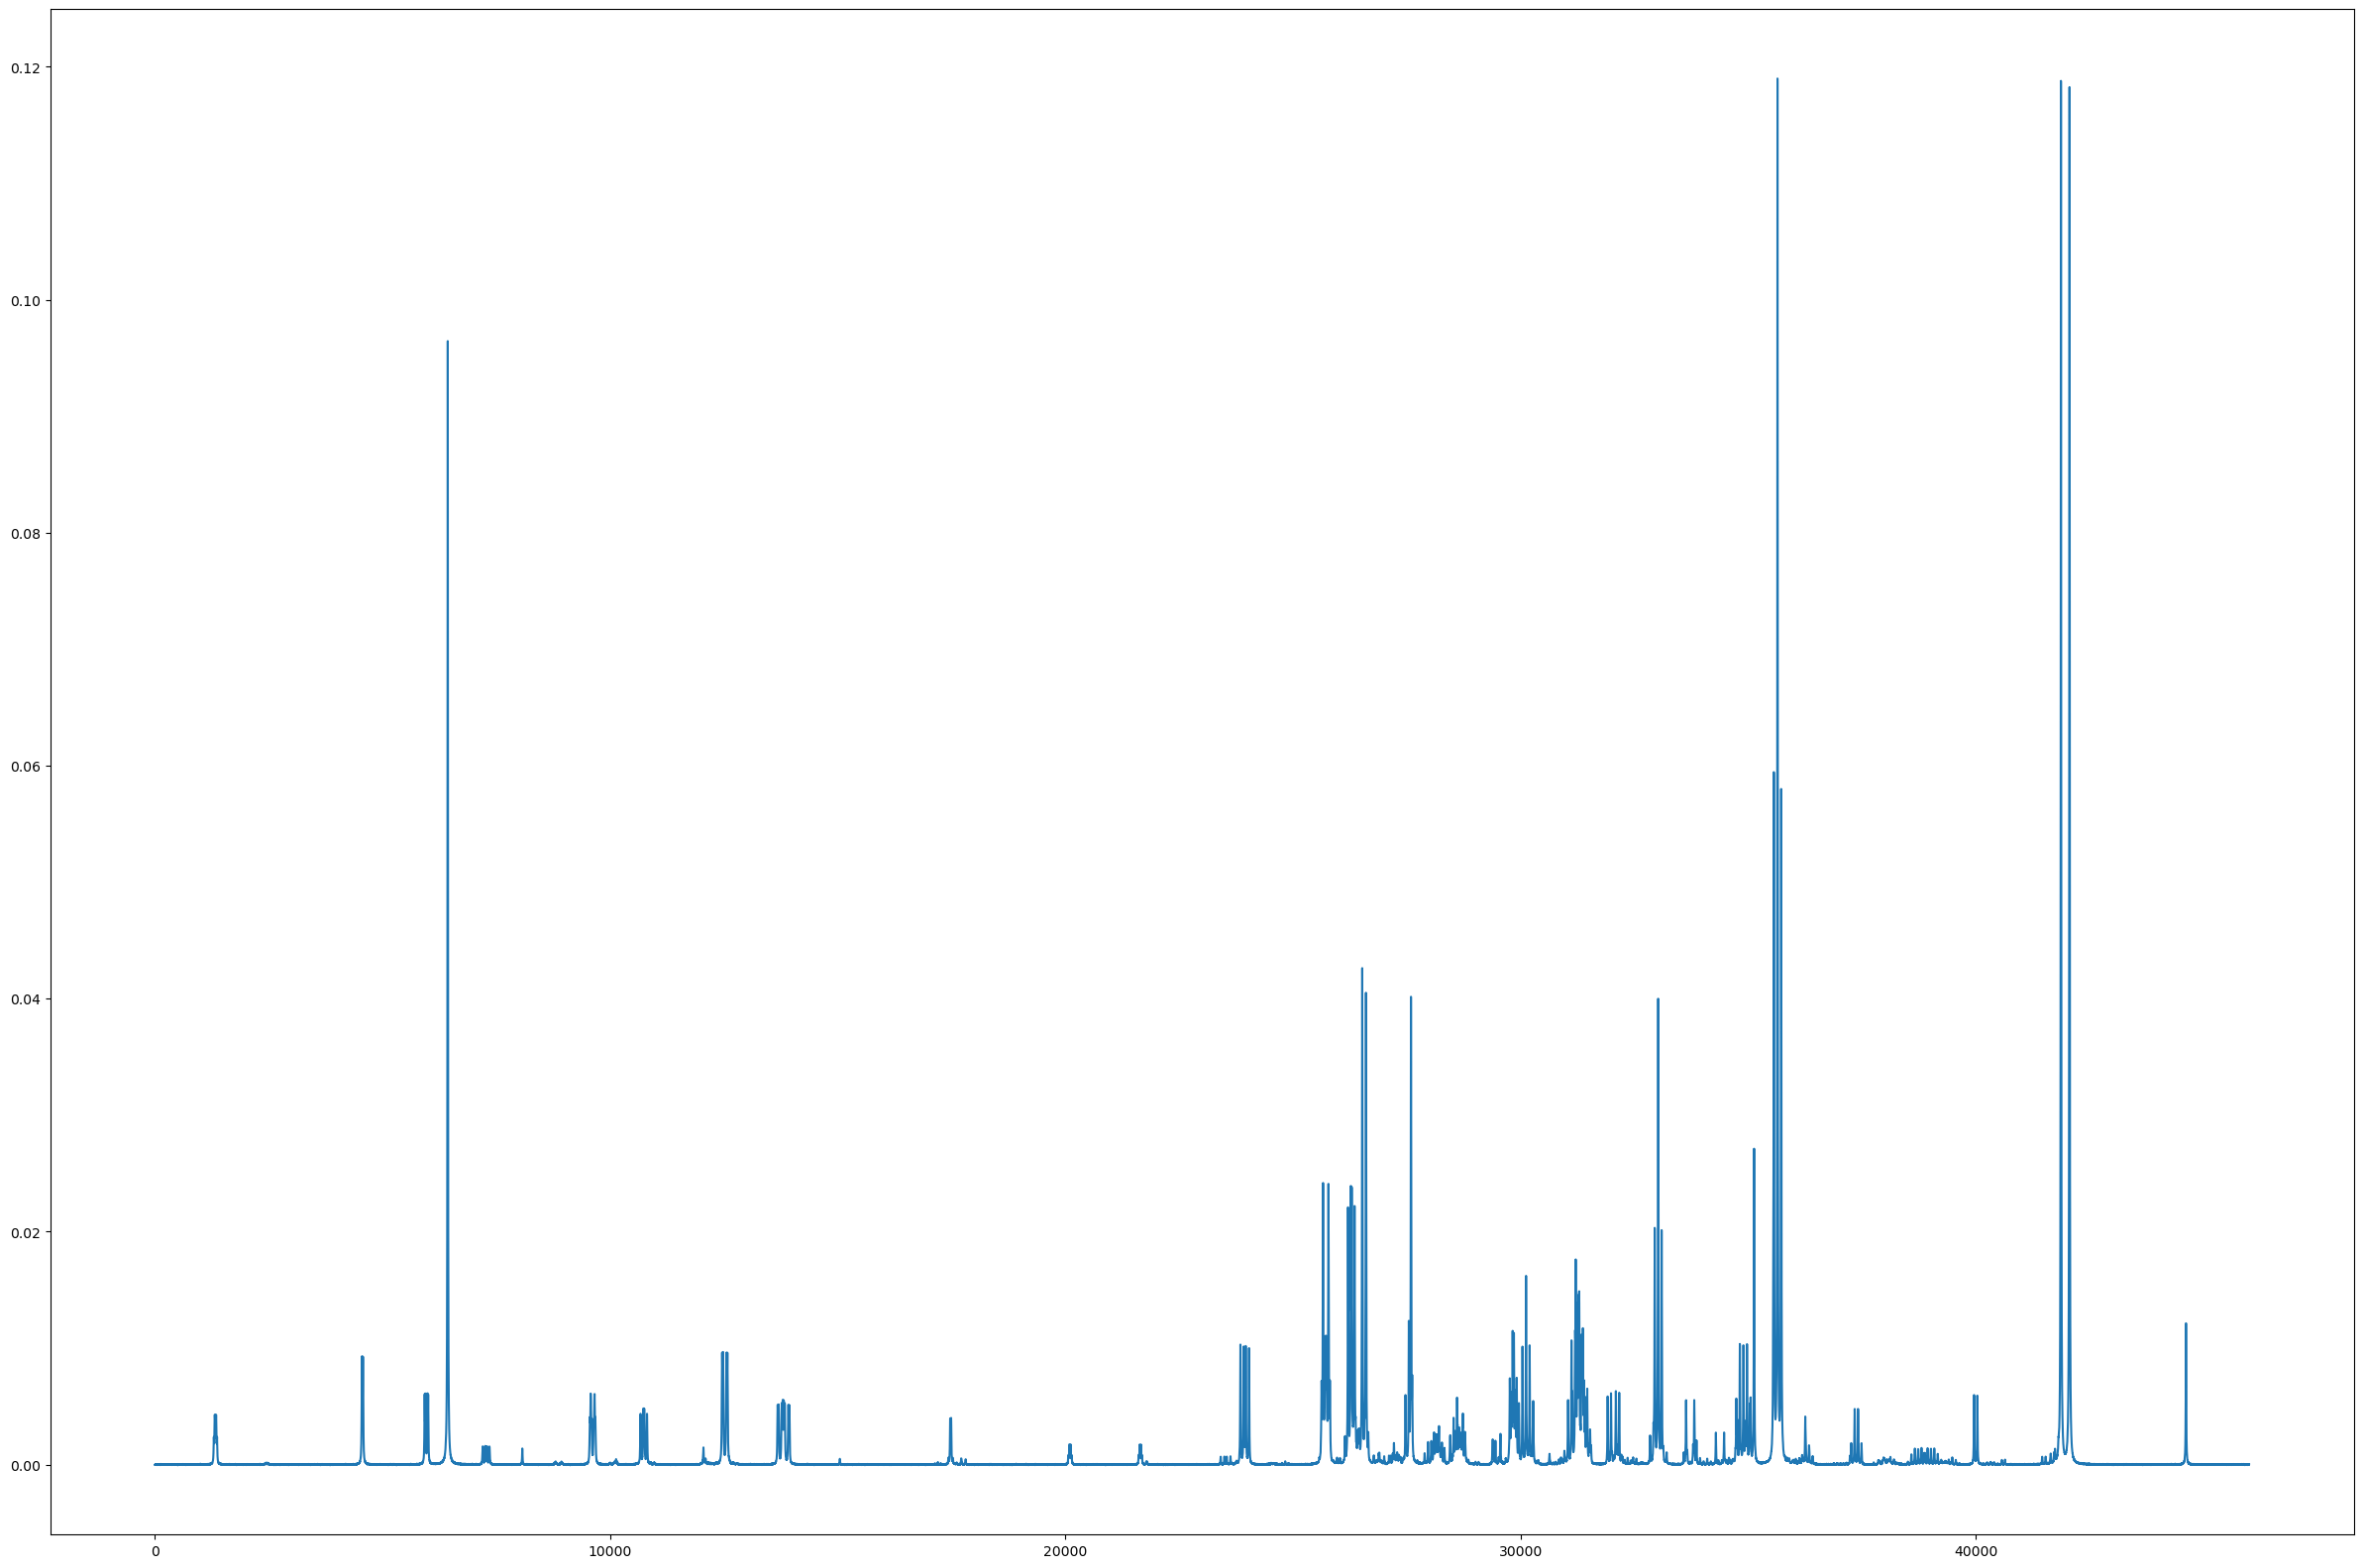

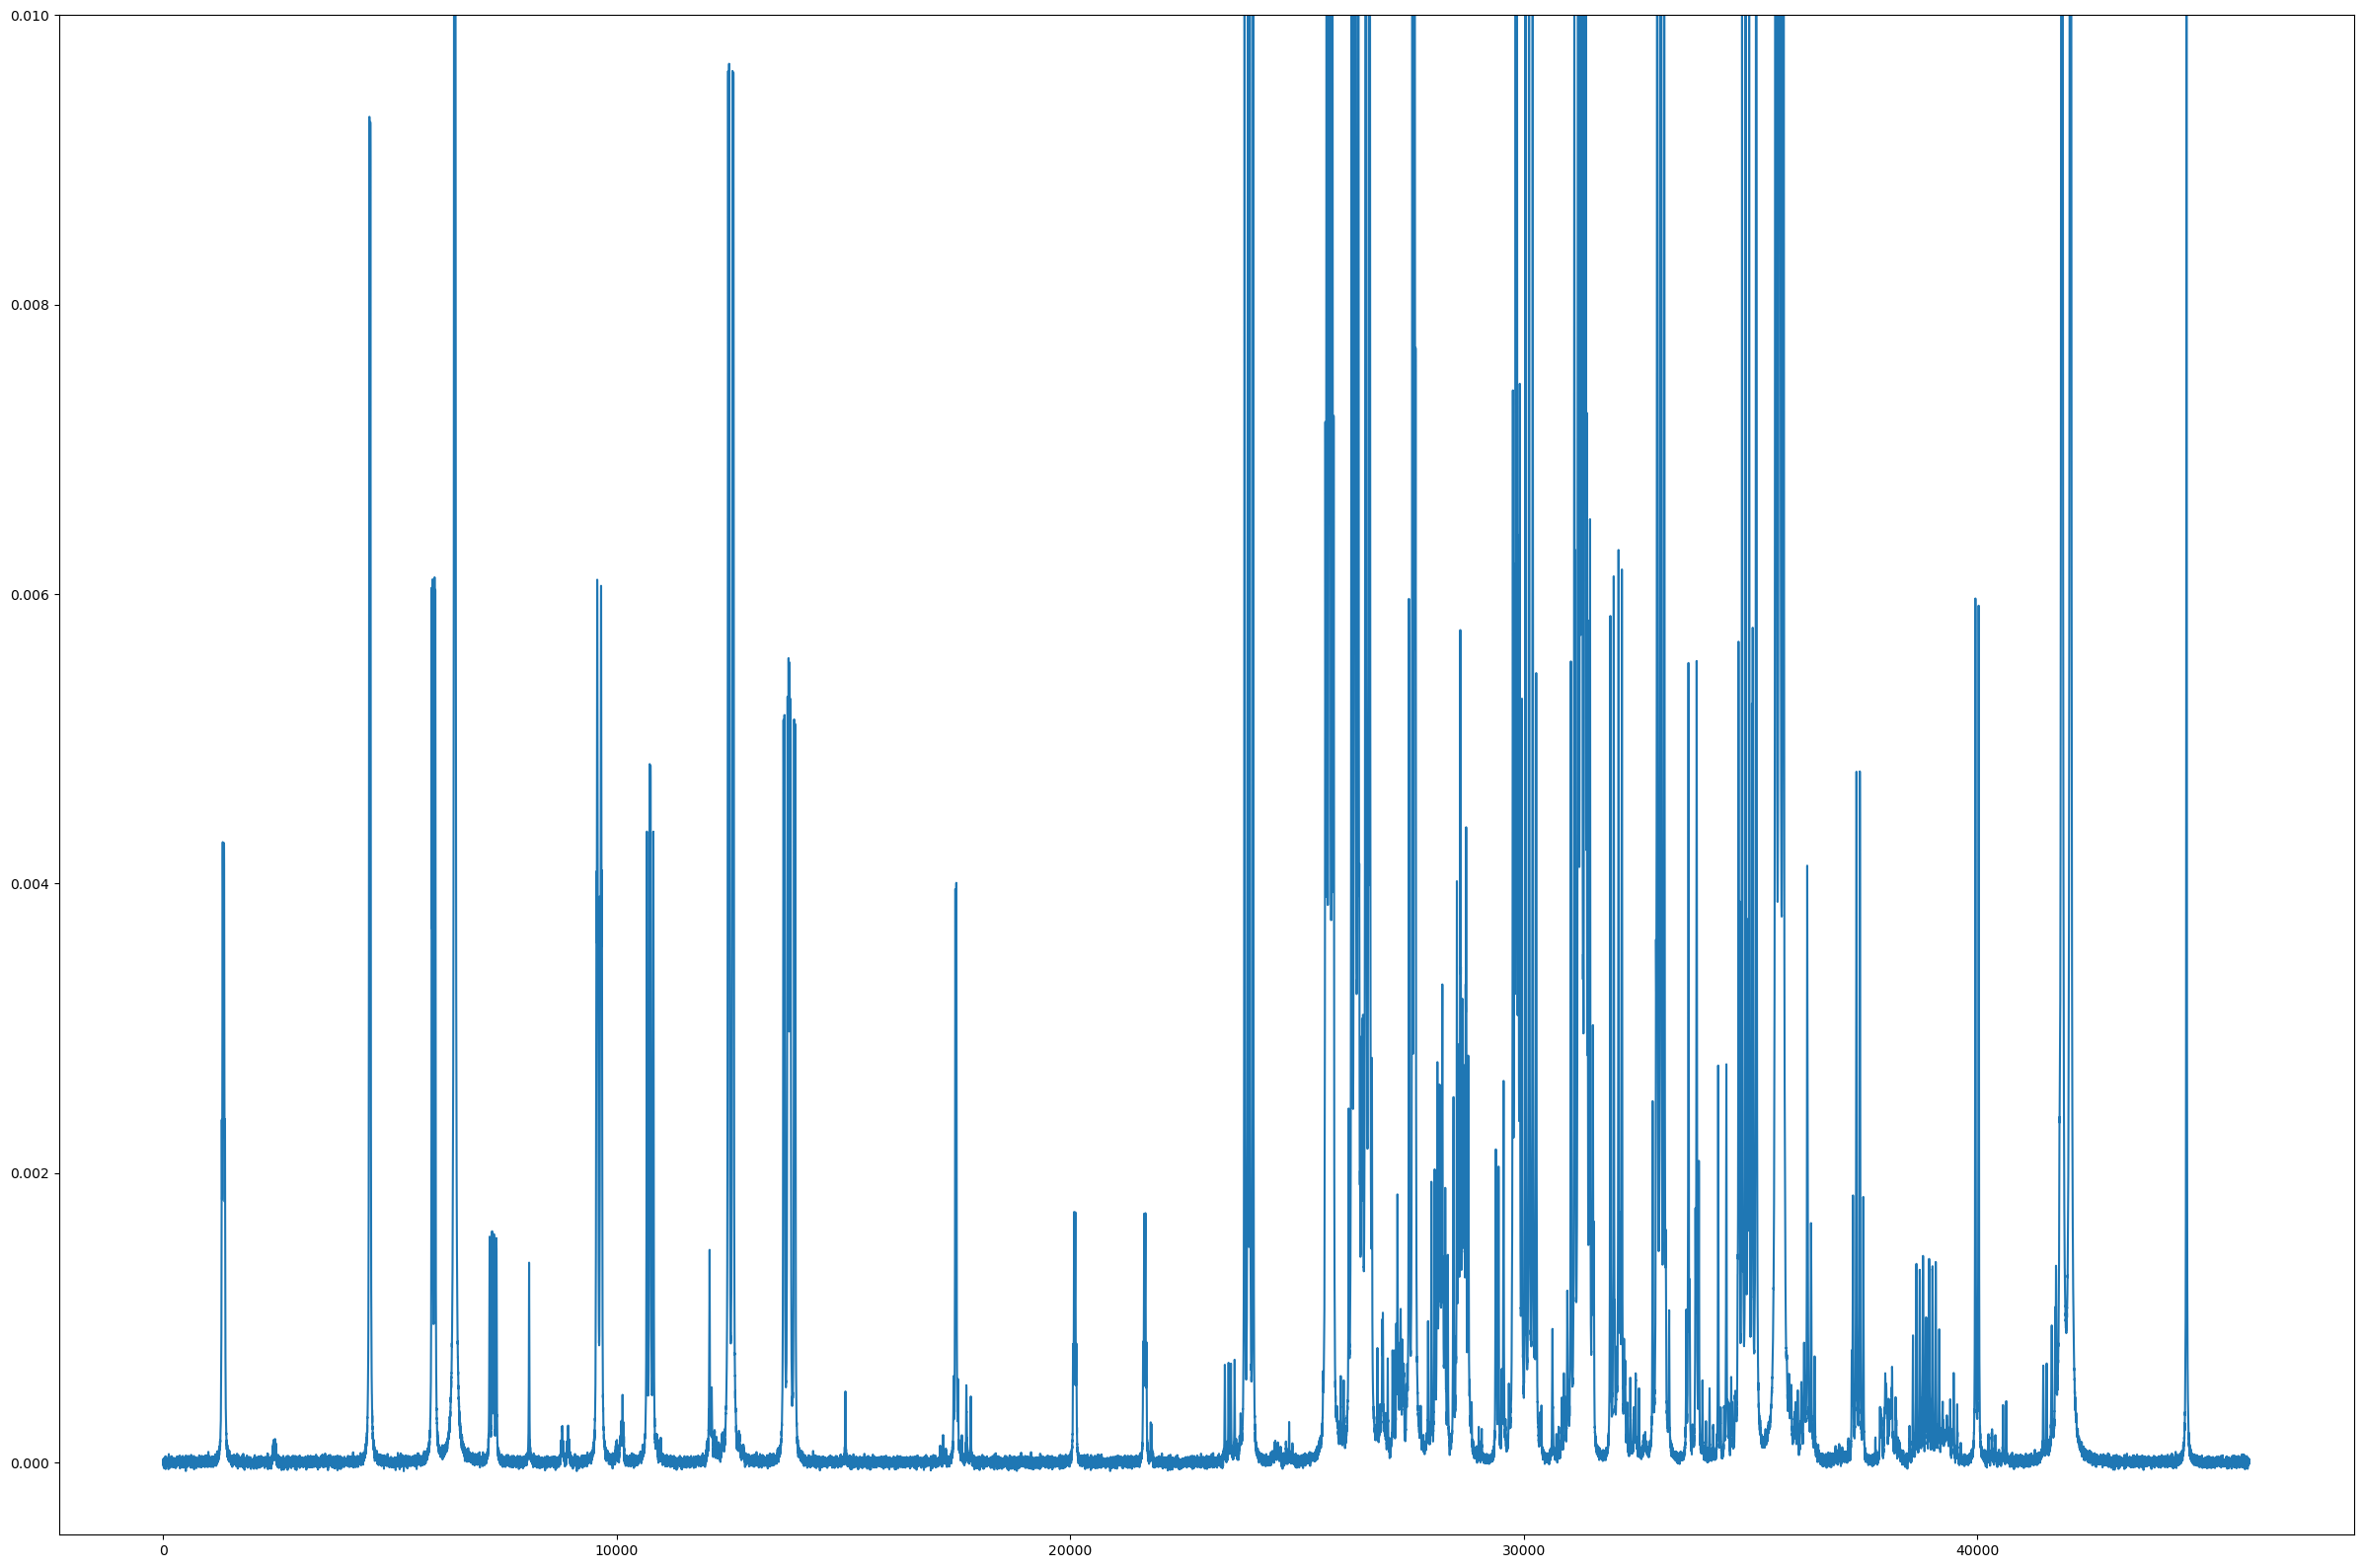

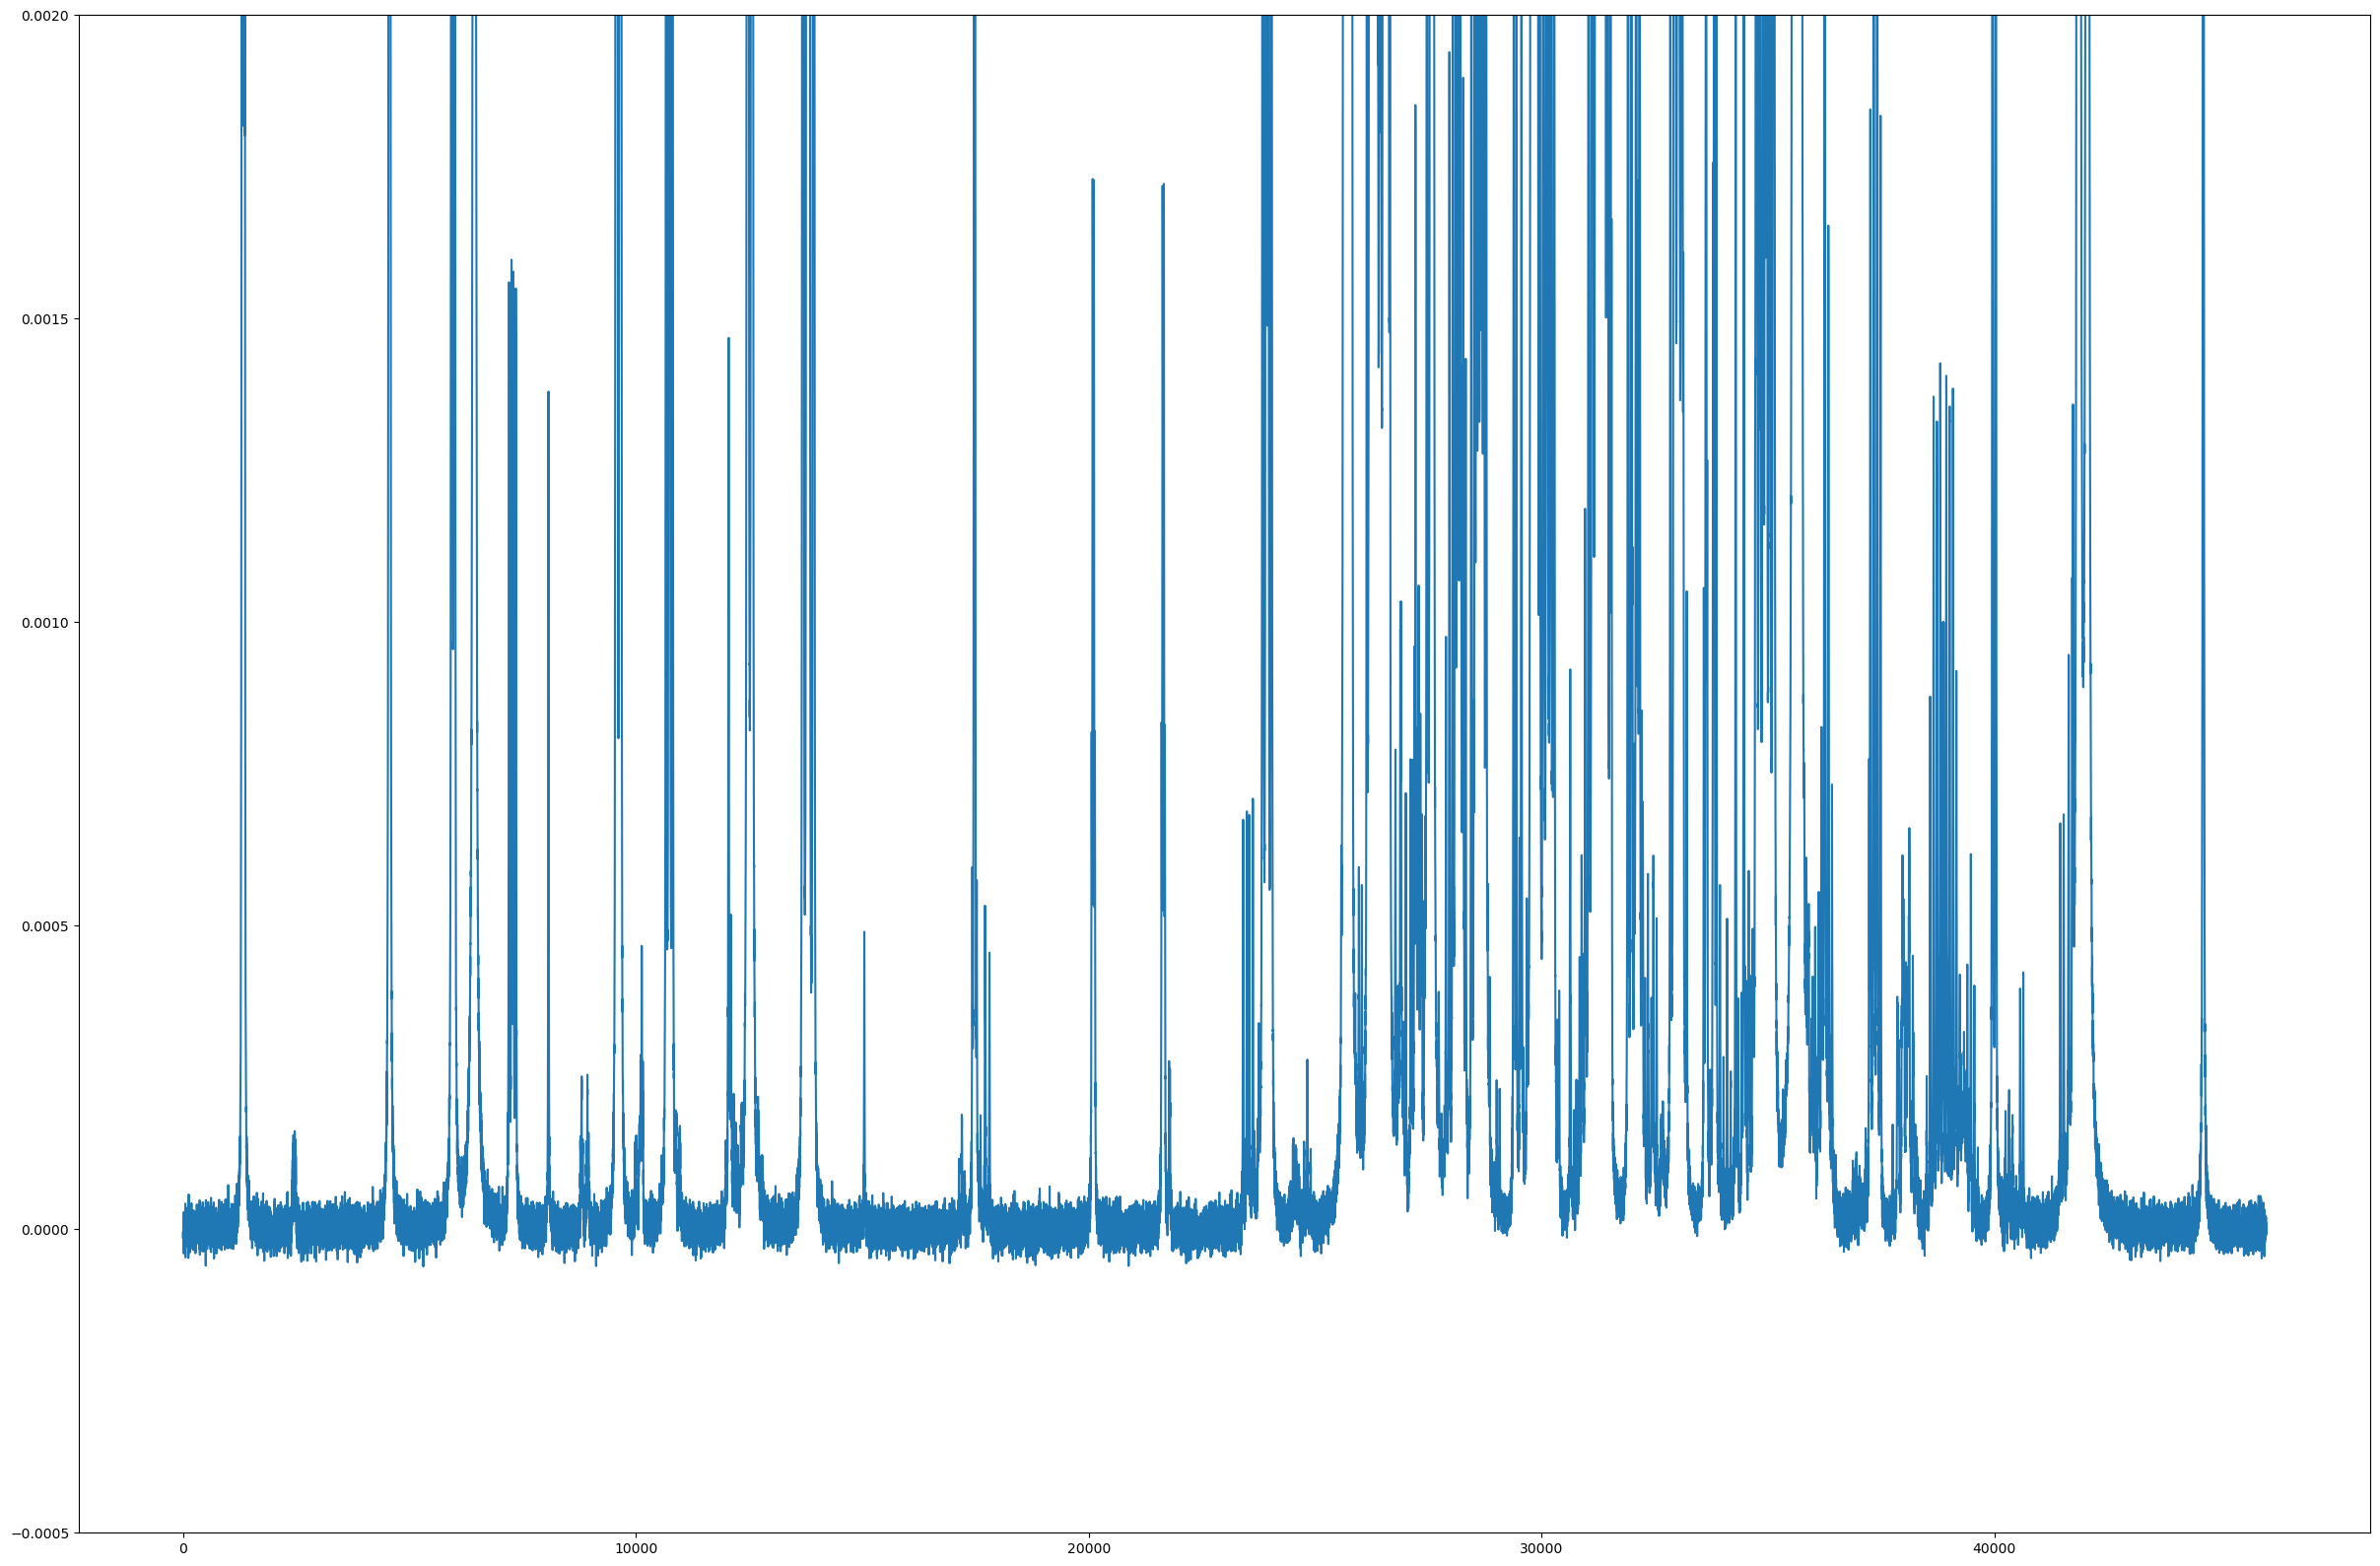

In [22]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [23]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  18.08807
--------------------
15.08  - Min Value: 0.013  - Mean Value: 0.6
19.44  - Min Value: 0.0115  - Mean Value: 0.4
11.95  - Min Value: 0.0115  - Mean Value: 0.4
14.85  - Min Value: 0.0115  - Mean Value: 0.6
22.2  - Min Value: 0.0115  - Mean Value: 1.0
20.3  - Min Value: 0.0115  - Mean Value: 1.1
36.48  - Min Value: 0.0115  - Mean Value: 0.8
11.22  - Min Value: 0.0115  - Mean Value: 0.5
7.43  - Min Value: 0.0115  - Mean Value: 0.5
21.93  - Min Value: 0.0115  - Mean Value: 1.1


In [24]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  75.3633
--------------------
91.16  - Min Value: 0.0062  - Mean Value: 2.1
79.87  - Min Value: 0.006  - Mean Value: 3.7
60.66  - Min Value: 0.0066  - Mean Value: 4.3
87.0  - Min Value: 0.0094  - Mean Value: 4.3
87.51  - Min Value: 0.0068  - Mean Value: 4.9
79.98  - Min Value: 0.005  - Mean Value: 3.8
57.13  - Min Value: 0.0101  - Mean Value: 3.2
40.9  - Min Value: 0.0062  - Mean Value: 3.2
86.56  - Min Value: 0.0053  - Mean Value: 5.3
82.86  - Min Value: 0.0054  - Mean Value: 2.5


In [25]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [26]:
model_aq(ConcSpec[5])

tensor([[0.5005, 0.5070, 0.5088, 0.5004, 0.5124, 0.5001, 0.4915, 0.4922, 0.5001,
         0.4948, 0.5110, 0.4943, 0.4957, 0.4911, 0.4870, 0.4944, 0.5114, 0.5050,
         0.5018, 0.4981, 0.5031, 0.5077, 0.5184, 0.5021, 0.4973, 0.4939, 0.4996,
         0.5029, 0.4922, 0.4989, 0.5029, 0.4983, 0.5015, 0.5086, 0.5087, 0.5031,
         0.5035, 0.4941, 0.5021, 0.5010, 0.5037, 0.5093, 0.5096, 0.5199]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [27]:
model_aq(SNR_Spec[1])

tensor([[0.4292, 0.4388, 0.4369, 0.4257, 0.4420, 0.4268, 0.4216, 0.4205, 0.4300,
         0.4237, 0.4401, 0.4249, 0.4274, 0.4189, 0.4288, 0.4241, 0.4424, 0.4354,
         0.4323, 0.4276, 0.4334, 0.4401, 0.4442, 0.4322, 0.4261, 0.4253, 0.4267,
         0.4344, 0.4236, 0.4285, 0.4318, 0.4258, 0.4347, 0.4375, 0.4381, 0.4303,
         0.4361, 0.4289, 0.4270, 0.4310, 0.4310, 0.4381, 0.4384, 0.4478]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  1.51115556725992
--------------------
1.26
1.3
1.33
1.2
1.51
1.6
1.81
1.59
1.81
1.69


In [29]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  16.051263807156374
--------------------
1.19
1.34
1.37
5.98
20.82
21.03
21.42
24.93
29.82
32.62


In [30]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  28.149354716105268
--------------------
2.11
8.23
15.19
22.08
28.46
33.38
37.83
41.89
45.16
47.16


In [31]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4593, 0.5902, 0.3982, 0.6121, 0.4931, 0.4969, 0.4998, 0.6157, 0.6856,
        0.3954, 0.4332, 0.6517, 0.5483, 0.8556, 0.3613, 0.6500, 0.6262, 0.4778,
        0.5040, 0.3916, 0.5076, 0.8632, 0.3770, 0.5175, 0.5774, 0.4771, 0.5945,
        0.6819, 0.4828, 0.4528, 0.4413, 0.8007, 0.4537, 0.4283, 0.4506, 0.4890,
        0.4922, 0.4383, 0.6578, 0.4065, 0.4023, 0.5072, 0.5804, 0.4295],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3769, 0.5153, 0.1475, 0.5677, 0.4022, 0.3982, 0.3955, 0.1821, 0.4024,
        0.5359, 0.4133, 0.4560, 0.7651, 0.3645, 0.7319, 0.1351, 0.7742, 0.5467,
        0.4917, 0.3446, 0.2887, 0.4138, 0.5613, 0.5607, 0.3661, 0.4438, 0.2161,
        0.0000, 0.5209, 0.3933, 0.4088, 0.4230, 0.3518, 0.4509, 0.5145, 0.4634,
        0.6420, 0.7292, 0.5294, 0.3607, 0.4429, 0.7552, 0.2549, 0.1849],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a